In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from tqdm.notebook import tqdm

In [2]:
hbar = 1.0
m = 1.0

## Potential & Forces

In [3]:
V_coeffs = {
    'free': [0,0,0,0],
    'harmonic': [0,1/2,0,0],
    'slightly_anharmonic': [0,1/2,1/10,1/100],
    'anharmonic': [0,0,0,1/4]
}

# For coefficients [a_1, a_2, ...], the potential has the form a_1 x^1 + a_2 x^2 + ...

In [4]:
def Pot(potential, x):
    coeffs = V_coeffs[potential]
    pot = 0
    for i, c in enumerate(coeffs):
        pot += c * x**(i+1)
    return pot

def Force(potential, x):
    coeffs = V_coeffs[potential]
    force = 0
    for i, c in enumerate(coeffs):
        force += -c * (i+1) * x**i
    return force


## Exact Quantum Solution

Kubo-transformed correlation function:
$$
K_{AB}(t)=\frac{1}{Z}\sum_{|n\rangle}\sum_{|m\rangle} \mathrm{e}^{-\beta E_n}\mathrm{e}^{-\mathrm{i}(E_n-E_m)t/\hbar}A_{nm}B_{mn}\frac{\mathrm{e}^{\beta(E_n-E_m)-1}}{\beta(E_n-E_m)}
$$

We expand the eigenstates of interest in the basis of eigenstates of a harmonic oscillator with mass $m$ and unit angular frequency. Define *ladder operators*
\begin{align*}
    \hat{a}&=\sqrt{\frac{m}{2\hbar}}\left(\hat{x}+\frac{\mathrm{i}}{m}\hat{p}\right)\\
    \hat{a}^\dagger&=\sqrt{\frac{m}{2\hbar}}\left(\hat{x}-\frac{\mathrm{i}}{m}\hat{p}\right)
\end{align*}
acting on harmonic eigenstates as
\begin{align*}
    \hat{a} | n \rangle &= \sqrt{n} | n-1 \rangle\,,\\
    \hat{a}^\dagger | n \rangle &= \sqrt{n+1} | n+1 \rangle\,.
\end{align*}

The above relations can be reverted to obtain
\begin{align*}
    x&=\sqrt{\frac{\hbar}{2m}}(\hat{a}^\dagger+\hat{a})\,,\\
    p&=\mathrm{i}\sqrt{\frac{m\hbar}{2}}(\hat{a}^\dagger - \hat{a})\,.
\end{align*}


In [5]:
def exact(n_max, beta, potential, order=[1,1], t_end=20, delta_t=0.01):
    '''
        n_max: highest number of harmonic eigenstate expanded to.

        beta: inverse temperature.

        potential: choose from 'harmonic', 'slightly anharmonic' and 'anharmonic'.

        order: [i,j] gives the correlation of x^i with x^j (default value [1,1]).

        t_end: range of time (default value 20).
        
        delta_t: time interval (default value 0.01).
    '''
    pot_coeffs = V_coeffs[potential]

    max_order = int(max(order[0],order[1],len(pot_coeffs)))    # Suppose we want to correlate x^i with x^j, and the potential function has power of x up to x^k, then we need the matrix element up to x^m, where m = max(i, j, k).
    dim = n_max + max_order                 # a^m will lower the n+m state to n.

    # Annihilation operator
    a = np.zeros((dim, dim))
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)

    # Creation operator
    a_dag = a.T

    # Position operator and its powers
    x = np.sqrt(hbar/(2*m)) * (a + a_dag)

    # List of matrices [x, x^2, x^3, ..., x^m]
    x_powers = [x]
    for i in range(0,max_order-1):
        x_powers.append(x_powers[i] @ x)

    # Potential energy matrix
    V = np.zeros((dim,dim))
    for i in range(0,len(pot_coeffs)):
        V += pot_coeffs[i] * x_powers[i]
    
    # Kinetic energy matrix
    P = np.sqrt(m * hbar / 2) * (a_dag - a)
    T = -(P @ P) / (2 * m)

    # Hamiltonian
    H = T + V
    H = H[:n_max,:n_max]

    E, psi = eigh(H)

    # Partition function
    Boltzmann = np.exp(-beta * E)
    Z = np.sum(Boltzmann)

    # Operator A = x^i, B = x^j
    A = x_powers[order[0]-1][:n_max,:n_max]
    A_mel = psi.T @ A @ psi

    B = x_powers[order[1]-1][:n_max,:n_max]
    B_mel = psi.T @ B @ psi

    # Build outer products for broadcasting
    E_m, E_n = np.meshgrid(E, E, indexing='ij')
    dE = E_m - E_n
    eps = 1e-10

    # Weight matrix with zero-division protection
    with np.errstate(divide='ignore', invalid='ignore'):
        weight_matrix = np.where(
            np.abs(dE) < eps,
            Boltzmann[:, None],
            (Boltzmann[None, :] - Boltzmann[:, None]) / (beta * dE)
        )

    # A_nm * B_mn
    AB_prod = A_mel * B_mel.T

    # Time evolution
    times = np.arange(0, t_end, delta_t)
    phase_factors = np.exp(1j * dE[None, :, :] * times[:, None, None] / hbar)  # shape: (t_N, M, M)

    C_t = np.einsum('ijk,jk,jk->i', phase_factors, weight_matrix, AB_prod).real / Z

    return times, C_t


## Classical Solution

We propagate the state via the velocity verlet algorithm.
\begin{align*}
    x_{n+1}&=x_n + v_n\delta t + \frac{F_n\delta t^2}{2m}\,, \\
    v_{n+1}&= v_n + \frac{(F_n + F_{n+1})\delta t}{2m}\,.
\end{align*}

We use an Andersen thermostat to re-draw the velocity from Maxwell&ndash;Boltzmann distribution after each sampling. For a particle of mass $m$ at inverse temperature $\beta$, the Maxwell&ndash;Boltzmann distribution is
$$f(v)=\sqrt{\frac{\beta m}{2\pi}}\exp\left(-\frac{\beta m v^2}{2}\right)\,,$$
i.e. a Gaussian distribution of variance $\sigma^2=1/\beta m$.

In [6]:
def verlet(x_init, v_init, potential, t_end, delta_t):
    '''
        x_init: initial coordinate.

        v_init: initial velocity.

        potential: choose from 'harmonic', 'slightly anharmonic' and 'anharmonic'.

        t_end: range of time.

        delta_t: time_interval.

    '''
    t_values = np.arange(0, t_end, delta_t)
    N = len(t_values)

    x_verlet = np.zeros(N)
    v_verlet = np.zeros(N)
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    f = Force(potential, x_init)
    for i in range(N - 1):
        x_new = x_verlet[i] + delta_t * v_verlet[i] + 0.5 * delta_t**2 * f / m
        f_new = Force(potential, x_new)
        v_new = v_verlet[i] + 0.5 * delta_t * (f + f_new) / m

        f = f_new
        x_verlet[i + 1] = x_new
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [7]:
def classical(beta, potential, N_samp, order=[1,1], t_end=20, delta_t=0.05):
    '''
        beta: inverse temperature.

        potential: choose from 'harmonic', 'slightly anharmonic' and 'anharmonic'.

        N_samp: number of samples.

        order: [i,j] gives the correlation of x^i with x^j (default value [1,1]).

        t_end: range of time (default value 20).
        
        delta_t: time interval (default value 0.05).
    '''
    C_time = np.arange(0, t_end, delta_t)
    C_func = np.zeros(len(C_time))

    x_init = 1
    
    for i in tqdm(range(0, N_samp+1), desc="Classical Sampling"):
        v_init = np.random.normal(0, 1/np.sqrt(beta*m))     # Resample velocity from Maxwell-Boltzmann
        x_samp, _ = verlet(x_init, v_init, potential, t_end, delta_t)
        x_corr = x_init**(order[0]) * x_samp**(order[1])
        if i > 0:                               # Ignore the first sample.
            C_func += x_corr/N_samp
        x_init = x_samp[-1]                     # Keep the coordinate for the next run.
        
    return C_time, C_func

## Ring Polymer

We again propagate the dynamics using the velocity verlet algorithm with an Andersen thermostat. The classical ring polymer Hamiltonian is
$$H=\sum_{i=1}^{N}\frac{p_i^2}{2m}+\frac{1}{2}k_{\text{eff}}(q_i-q_{i+1})^2+V(x_i)\,,$$
where
$$k_{\text{eff}}=\frac{m}{\beta_N^2\hbar^2}\,.$$

The internal normal modes motions, with Hamiltonian
$$H_{\text{int}}=\sum_{i=1}^{N}\frac{1}{2}m\dot{q}_i^2+\frac{1}{2}k_{\text{eff}}(q_i-q_{i+1})^2\,,$$
are exactly solvable. Define kinetic and potential matrices
$$\mathsf{T}=m\mathsf{I}\,,\ \mathsf{V}=k_{\text{eff}}\begin{pmatrix}
2 & -1 & 0 & \cdots & -1 \\
-1 & 2 & -1 & \cdots & 0 \\
0 & -1 & 2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-1 & 0 & 0 & \cdots & 2
\end{pmatrix}\,.$$
Normal mode frequencies are solved by
$$\det(\mathsf{V}-\omega_n^2\mathsf{T})=0\,,$$
which are
$$\omega_n^2=\frac{k_{\text{eff}}}{m}\left[2-2\cos\frac{2\pi n}{N}\right]\,,$$
and the eigenvectors are
$$Q_s^{(n)}=\sqrt{\frac{1}{N}}\mathrm{e}^{2\pi\mathrm{i}ns/N}\,.$$
Inner product with these eigenvectors are therefore exactly the discrete Fourier transform.


In [8]:
def normal_mode_frequencies(k_eff, n):
    lambda_n = 2 - 2 * np.cos(2 * np.pi * np.arange(n) / n)
    omega_n = np.sqrt(k_eff * lambda_n / m)
    return omega_n

def mode_propagation(x, v, omega, delta_t):
    #Transform to normal coordinates
    Xk = np.fft.fft(x)
    Vk = np.fft.fft(v)

    Xk_next = np.empty_like(Xk)
    Vk_next = np.empty_like(Vk)

    #Evolve the omega=0 mode
    Xk_next[0] = Xk[0] + Vk[0] * delta_t
    Vk_next[0] = Vk[0]

    # Evolve the omgea>0 mode
    omega_pos = omega[1:]
    coswt = np.cos(omega_pos*delta_t)
    sinwt = np.sin(omega_pos*delta_t)
    Xk_pos = Xk[1:]
    Vk_pos = Vk[1:]
    Xk_next[1:] = Xk_pos * coswt + Vk_pos * (sinwt / omega_pos)
    Vk_next[1:] = Vk_pos * coswt - Xk_pos * (omega_pos * sinwt)
    
    # Transform back to real coordinates
    x_next = np.fft.ifft(Xk_next, axis=0).real
    v_next = np.fft.ifft(Vk_next, axis=0).real
    return x_next, v_next


In [9]:
def polymer_verlet(x_init, v_init, k_eff, potential, t_end, delta_t, n):
    '''
        x_init: initial coordinates of shape (n).

        v_init: initial velocities of shape (n).

        k_eff: effective force constant of the polymer.

        potential: choose from 'harmonic', 'slightly anharmonic' and 'anharmonic'.

        t_end: range of time.

        delta_t: time_interval.

        n: number of beads in the ring polymer.
    '''
    t_values = np.arange(0, t_end, delta_t)
    N = len(t_values)

    omega = normal_mode_frequencies(k_eff, n)

    x_verlet = np.zeros((N, n))
    v_verlet = np.zeros((N, n))
    x_verlet[0] = x_init
    v_verlet[0] = v_init

    f = Force(potential, x_init)
    for i in range(N - 1):
        v_half = v_verlet[i] + 0.5 * delta_t * f / m                                # Propagate velocity half step by external potential
        x_mode, v_mode = mode_propagation(x_verlet[i], v_half, omega, delta_t)      # Propagate velocity and coordinate by mode vibration
        f_new = Force(potential, x_mode)
        v_new = v_mode + 0.5 * delta_t * f_new / m                                  # Propagate velocity half step by external potential

        f = f_new
        x_verlet[i + 1] = x_mode
        v_verlet[i + 1] = v_new

    return x_verlet, v_verlet

In [10]:
def polymer(beta, potential, n, N_samp, order=[1,1], t_end=20, delta_t=0.05):
    '''
        beta: inverse temperature.

        potential: choose from 'harmonic', 'slightly anharmonic' and 'anharmonic'.

        n: number of beads in polymer ring.

        N_samp: number of samples.

        order: [i,j] gives the correlation of x^i with x^j (default value [1,1]).

        t_end: range of time (default value 20).
        
        delta_t: time interval (default value 0.05).
    '''
    beta_n = beta / n
    k_eff = m / (beta_n**2 * hbar**2)

    C_time = np.arange(0, t_end, delta_t)
    C_func = np.zeros(len(C_time))

    x_init = np.zeros(n)
    
    for i in tqdm(range(0, N_samp+1), desc="Polymer Sampling"):
        v_init = np.random.normal(0, 1/np.sqrt(beta_n*m), n)     # Resample velocity from Maxwell-Boltzmann
        x_samp, _ = polymer_verlet(x_init, v_init, k_eff, potential, t_end, delta_t, n)
        x_init_avg = np.mean(x_init**(order[0]))
        x_samp_avg = np.mean(x_samp**(order[1]), axis=1)
        x_corr = x_init_avg * x_samp_avg
        if i > 0:                               # Ignore the first sample.
            C_func += x_corr/N_samp
        x_init = x_samp[-1]                     # Keep the coordinate for the next run.
        
    return C_time, C_func

## $C_{xx}$

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [46]:
beta = 1
n = 4*beta
exact_harm = exact(10,beta,'harmonic')
classical_harm = classical(beta ,'harmonic', 20000)
polymer_harm = polymer(beta ,'harmonic', n, 20000)

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

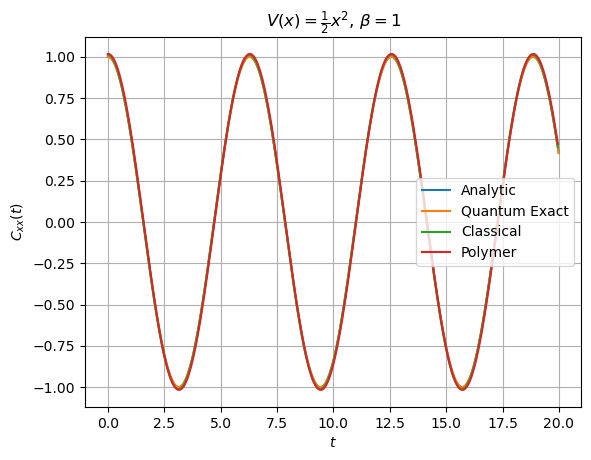

In [47]:
plt.plot(exact_harm[0], np.cos(exact_harm[0]), label='Analytic')
plt.plot(exact_harm[0], exact_harm[1], label='Quantum Exact')
plt.plot(classical_harm[0], classical_harm[1], label='Classical')
plt.plot(polymer_harm[0], polymer_harm[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [11]:
beta = 1
n = 4*beta
exact_sanh_highT = exact(20,beta,'slightly_anharmonic')
class_sanh_highT = classical(beta,'slightly_anharmonic', 40000)
polymer_sanh_highT = polymer(beta ,'slightly_anharmonic', n, 40000)

Classical Sampling:   0%|          | 0/40001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/40001 [00:00<?, ?it/s]

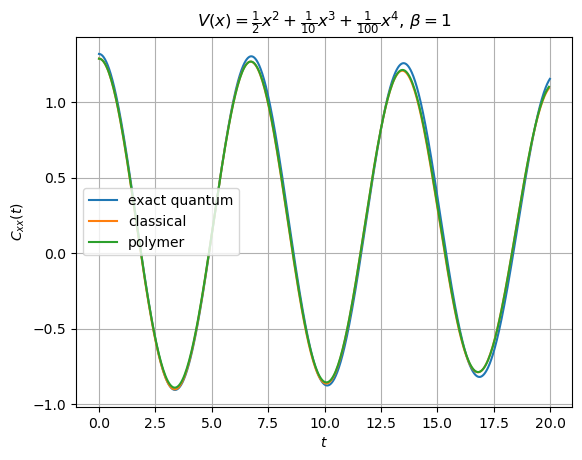

In [12]:
plt.plot(exact_sanh_highT[0], exact_sanh_highT[1], label='exact quantum')
plt.plot(class_sanh_highT[0], class_sanh_highT[1], label='classical')
plt.plot(polymer_sanh_highT[0], polymer_sanh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [86]:
beta = 8
n = 4*beta
exact_sanh_lowT = exact(20,beta,'slightly_anharmonic')
class_sanh_lowT = classical(beta,'slightly_anharmonic', 20000)
polymer_sanh_lowT = polymer(beta,'slightly_anharmonic', n, 20000, delta_t = 0.03)

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

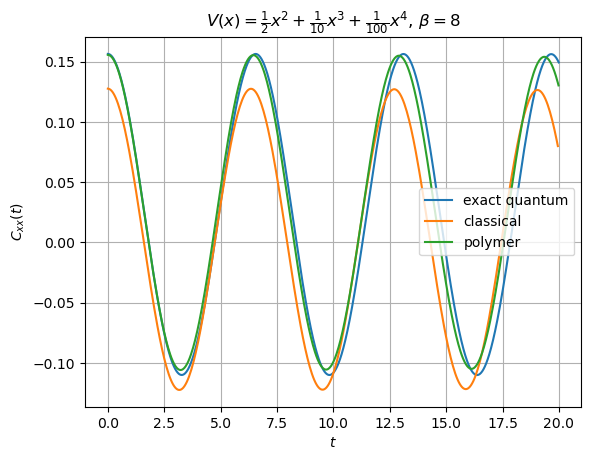

In [87]:
plt.plot(exact_sanh_lowT[0], exact_sanh_lowT[1], label='exact quantum')
plt.plot(class_sanh_lowT[0], class_sanh_lowT[1], label='classical')
plt.plot(polymer_sanh_lowT[0], polymer_sanh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [ ]:
beta = 1
n = 4*beta
exact_anh_highT = exact(20,beta,'anharmonic')
class_anh_highT = classical(beta,'anharmonic', 20000)
polymer_anh_highT = polymer(beta ,'anharmonic', n, 20000)

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

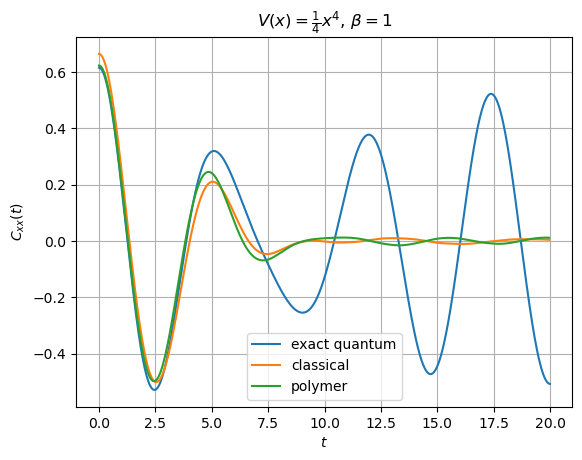

In [ ]:
plt.plot(exact_anh_highT[0], exact_anh_highT[1], label='exact quantum')
plt.plot(class_anh_highT[0], class_anh_highT[1], label='classical')
plt.plot(polymer_anh_highT[0], polymer_anh_highT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [88]:
beta = 8
n = 4*beta
exact_anh_lowT = exact(20,beta,'anharmonic')
class_anh_lowT = classical(beta,'anharmonic',20000)
polymer_anh_lowT = polymer(beta ,'anharmonic', n, 20000)

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

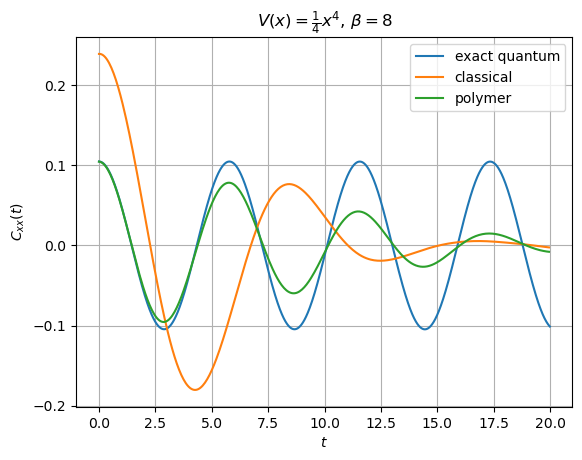

In [89]:
plt.plot(exact_anh_lowT[0], exact_anh_lowT[1], label='exact quantum')
plt.plot(class_anh_lowT[0], class_anh_lowT[1], label='classical')
plt.plot(polymer_anh_lowT[0], polymer_anh_lowT[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{xx}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


## $C_{x^3 x^3}$

$V(x)=\frac{1}{2}x^2$, $\beta=1$

In [100]:
beta = 1
n = 4*beta
exact_harm_highT_cube = exact(10,beta,'harmonic', [3,3])
classical_harm_highT_cube = classical(beta ,'harmonic', 20000, [3,3])
polymer_harm_highT_cube = polymer(beta ,'harmonic', n, 20000, [3,3])

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

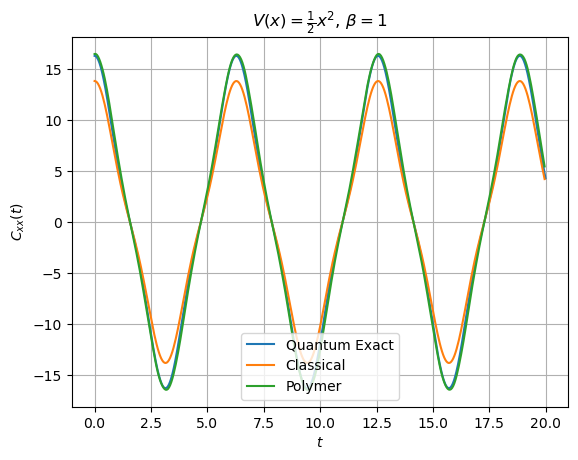

In [ ]:
plt.plot(exact_harm_highT_cube[0], exact_harm_highT_cube[1], label='Quantum Exact')
plt.plot(classical_harm_highT_cube[0], classical_harm_highT_cube[1], label='Classical')
plt.plot(polymer_harm_highT_cube[0], polymer_harm_highT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2$, $\beta=8$

In [98]:
beta = 8
n = 4*beta
exact_harm_lowT_cube = exact(10,beta,'harmonic', [3,3])
classical_harm_lowT_cube = classical(beta ,'harmonic', 20000, [3,3])
polymer_harm_lowT_cube = polymer(beta ,'harmonic', n, 20000, [3,3])

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

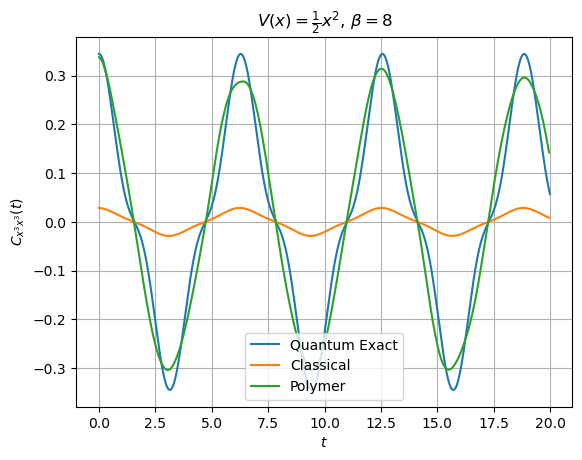

In [110]:
plt.plot(exact_harm_lowT_cube[0], exact_harm_lowT_cube[1], label='Quantum Exact')
plt.plot(classical_harm_lowT_cube[0], classical_harm_lowT_cube[1], label='Classical')
plt.plot(polymer_harm_lowT_cube[0], polymer_harm_lowT_cube[1], label='Polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{2}x^2$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$

In [13]:
beta = 1
n = 4*beta
exact_sanh_highT_cube = exact(30,beta,'slightly_anharmonic', [3,3])
class_sanh_highT_cube = classical(beta,'slightly_anharmonic', 40000, [3,3], delta_t=0.02)
polymer_sanh_highT_cube = polymer(beta ,'slightly_anharmonic', n, 60000, [3,3], delta_t=0.02)

Classical Sampling:   0%|          | 0/40001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/60001 [00:00<?, ?it/s]

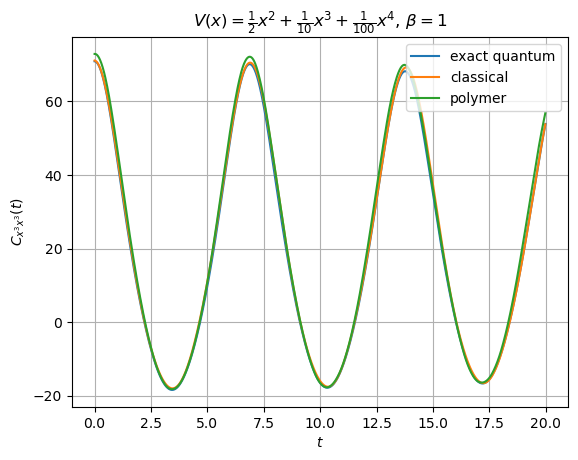

In [14]:
plt.plot(exact_sanh_highT_cube[0], exact_sanh_highT_cube[1], label='exact quantum')
plt.plot(class_sanh_highT_cube[0], class_sanh_highT_cube[1], label='classical')
plt.plot(polymer_sanh_highT_cube[0], polymer_sanh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=1$')
plt.legend()
plt.show()


$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$

In [104]:
beta = 8
n = 4*beta
exact_sanh_lowT_cube = exact(20,beta,'slightly_anharmonic', [3,3])
class_sanh_lowT_cube = classical(beta,'slightly_anharmonic', 20000, [3,3])
polymer_sanh_lowT_cube = polymer(beta,'slightly_anharmonic', n, 20000, [3,3])

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

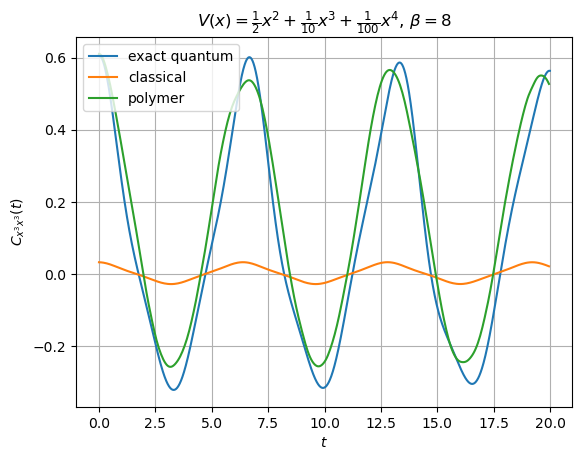

In [105]:
plt.plot(exact_sanh_lowT_cube[0], exact_sanh_lowT_cube[1], label='exact quantum')
plt.plot(class_sanh_lowT_cube[0], class_sanh_lowT_cube[1], label='classical')
plt.plot(polymer_sanh_lowT_cube[0], polymer_sanh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.grid()
plt.title(r'$V(x)=\frac{1}{2}x^2+\frac{1}{10}x^3+\frac{1}{100}x^4$, $\beta=8$')
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=1$

In [106]:
beta = 1
n = 4*beta
exact_anh_highT_cube = exact(20,beta,'anharmonic', [3,3])
class_anh_highT_cube = classical(beta,'anharmonic',20000, [3,3])
polymer_anh_highT_cube = polymer(beta ,'anharmonic', n, 20000, [3,3])

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

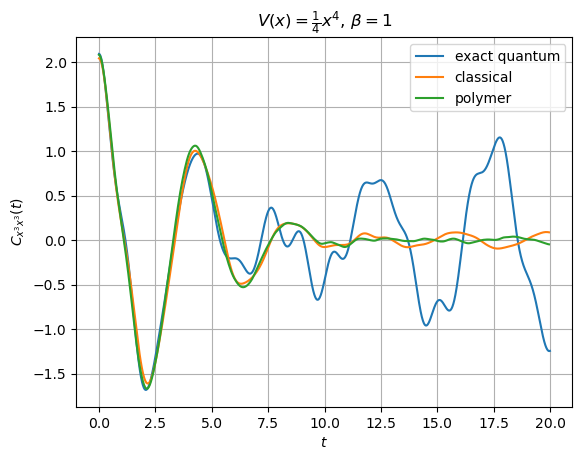

In [107]:
plt.plot(exact_anh_highT_cube[0], exact_anh_highT_cube[1], label='exact quantum')
plt.plot(class_anh_highT_cube[0], class_anh_highT_cube[1], label='classical')
plt.plot(polymer_anh_highT_cube[0], polymer_anh_highT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=1$')
plt.grid()
plt.legend()
plt.show()


$V(x)=\frac{1}{4}x^4$, $\beta=8$

In [108]:
beta = 8
n = 4*beta
exact_anh_lowT_cube = exact(20,beta,'anharmonic', [3,3])
class_anh_lowT_cube = classical(beta,'anharmonic',20000, [3,3])
polymer_anh_lowT_cube = polymer(beta ,'anharmonic', n, 20000, [3,3])

Classical Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

Polymer Sampling:   0%|          | 0/20001 [00:00<?, ?it/s]

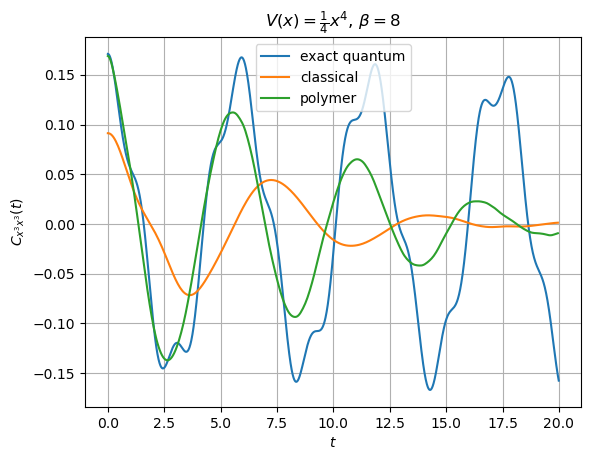

In [109]:
plt.plot(exact_anh_lowT_cube[0], exact_anh_lowT_cube[1], label='exact quantum')
plt.plot(class_anh_lowT_cube[0], class_anh_lowT_cube[1], label='classical')
plt.plot(polymer_anh_lowT_cube[0], polymer_anh_lowT_cube[1], label='polymer')
plt.xlabel(r'$t$')
plt.ylabel(r'$C_{x^3 x^3}(t)$')
plt.title(r'$V(x)=\frac{1}{4}x^4$, $\beta=8$')
plt.grid()
plt.legend()
plt.show()
